In [1]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
from ipywidgets import fixed, interact, interact_manual, interactive
from natsort import index_natsorted
from scipy.stats import norm

%load_ext line_profiler
%matplotlib inline
pyo.init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv("../../data/3_analysis-resistance/all_rgiout_2022-12-01", sep="\t")
df

,Accession_Number,Strain,Assembly_No,Year_Cultured,ORF_ID,Contig,Start,Stop,Orientation,Cut_Off,...,Resistance Mechanism,AMR Gene Family,Predicted_DNA,Predicted_Protein,CARD_Protein_Sequence,Percentage Length of Reference Sequence,ID,Model_ID,Nudged,Note
0,NCTC9079,Escherichia coli,1,1976,UGCB01000003.1_212 # 239453 # 240277 # 1 # ID=...,UGCB01000003.1_212,239453.0,240277.0,+,Perfect,...,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,ATGCAATCACTACATGGGAATTGTCTAATTGCGTATGCAAGACATA...,MQSLHGNCLIAYARHKYILTMVNGEYRYFNGGDLVFADASQIRVDK...,MQSLHGNCLIAYARHKYILTMVNGEYRYFNGGDLVFADASQIRVDK...,100.00,gnl|BL_ORD_ID|78|hsp_num:0,91.0,NaN,NaN
1,NCTC9079,Escherichia coli,1,1976,UGCB01000003.1_213 # 240646 # 241374 # 1 # ID=...,UGCB01000003.1_213,240646.0,241374.0,+,Strict,...,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,ATGACTCATGTCTGCTCGGTGATCCTCATTCGTCGTTCATTCGATA...,MTHVCSVILIRRSFDIYHEQQKISLHNESILLLEKNLADDFAFCSP...,MAHVCSVILVRRSFDIHHEQQKISLHNESILLLDKNLADDFAFCSL...,100.00,gnl|BL_ORD_ID|2086|hsp_num:0,2324.0,NaN,NaN
2,NCTC9079,Escherichia coli,1,1976,UGCB01000003.1_215 # 241736 # 244849 # -1 # ID...,UGCB01000003.1_215,241736.0,244849.0,-,Perfect,...,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,ATGGCTAACTATTTTATTGATCGCCCGGTTTTTGCCTGGGTACTTG...,MANYFIDRPVFAWVLAIIMMLAGGLAIMNLPVAQYPQIAPPTITVS...,MANYFIDRPVFAWVLAIIMMLAGGLAIMNLPVAQYPQIAPPTITVS...,100.00,gnl|BL_ORD_ID|103|hsp_num:0,121.0,NaN,NaN
3,NCTC9079,Escherichia coli,1,1976,UGCB01000003.1_216 # 244874 # 246031 # -1 # ID...,UGCB01000003.1_216,244874.0,246031.0,-,Perfect,...,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,ATGAACAGAAGAAGAAAGCTGTTAATACCGTTGTTATTCTGCGGCG...,MNRRRKLLIPLLFCGAMLTACDDKSAENAAAMTPEVGVVTLSPGSV...,MNRRRKLLIPLLFCGAMLTACDDKSAENAAAMTPEVGVVTLSPGSV...,100.00,gnl|BL_ORD_ID|1758|hsp_num:0,1903.0,NaN,NaN
4,NCTC9079,Escherichia coli,1,1976,UGCB01000003.1_370 # 416530 # 417162 # -1 # ID...,UGCB01000003.1_370,416530.0,417162.0,-,Strict,...,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,ATGGTGCTTGGCAAACCGCAAACAGACCCGACTCTCGAATGGTTCT...,MVLGKPQTDPTLEWFLSHCHIHKYPSKSTLIHQGEKAETLYYIVKG...,MVLGKPQTDPTLEWFLSHCHIHKYPSKSKLIHQGEKAETLYYIVKG...,100.00,gnl|BL_ORD_ID|803|hsp_num:0,869.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31498,NCTC11010,Oligella urethralis,1,1970,UGRW01000001.1_146 # 163892 # 164239 # 1 # ID=...,UGRW01000001.1_146,163892.0,164239.0,+,Strict,...,antibiotic efflux,small multidrug resistance (SMR) antibiotic ef...,ATGCAGCCAACAATAGCAGCTTATTGTTTTTTGGCGATTGCTATTT...,MQPTIAAYCFLAIAIFFELVGTSLLIKTEQFTRLIPSALVLISYGS...,MHYLYLFISIATEIIGTSFLKTSEGFTKLWPTLGTLLSFGICFYFL...,107.48,gnl|BL_ORD_ID|4668|hsp_num:0,5731.0,NaN,NaN
31499,NCTC11012,Moraxella equi,1,1970,UGQF01000001.1_2 # 1441 # 1689 # 1 # ID=1_2;pa...,UGQF01000001.1_2,1441.0,1689.0,+,Strict,...,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,ATGTTAATCCTAACCCGCCGTGTTGGCGAAACCCTAATGATTGGCG...,MLILTRRVGETLMIGDEVSVTVLGVKGNQVRLGVNAPKDIAVHREE...,MLILTRRVGETLMVGDDVTVTVLGVKGNQVRIGVNAPKEVAVHREE...,134.43,gnl|BL_ORD_ID|2800|hsp_num:0,3807.0,NaN,NaN
31500,NCTC11012,Moraxella equi,1,1970,UGQF01000001.1_451 # 440623 # 440964 # -1 # ID...,UGQF01000001.1_451,440623.0,440964.0,-,Strict,...,antibiotic efflux,small multidrug resistance (SMR) antibiotic ef...,ATGCAACTCTCTACCGCTTACGCCCTGCTCGCCCTTGCCATCATCA...,MQLSTAYALLALAIISEVTGSTFLAKSDGFSKLIPTCITLTGFAIA...,MHYLYLFISIATEIIGTSFLKTSEGFTKLWPTLGTLLSFGICFYFL...,105.61,gnl|BL_ORD_ID|4668|hsp_num:0,5731.0,NaN,NaN
31501,NCTC11012,Moraxella equi,1,1970,UGQF01000001.1_979 # 1020955 # 1021812 # 1 # I...,UGQF01000001.1_979,1020955.0,1021812.0,+,Strict,...,antibiotic target alteration,vanY; glycopeptide resistance gene cluster,ATGAAAAAACGCACAAGAGATTTATTGATTGGTGCAGGGCTTTTGG...,MKKRTRDLLIGAGLLGVGTVGAIAMFTNNQSGSGYIASPSKNTVHV...,MEKSNYHSNVNHHKRHMKQSGEKRAFLWAFIISFTVCTLFLGWRLV...,106.34,gnl|BL_ORD_ID|602|hsp_num:0,556.0,NaN,NaN


In [3]:
print(df.drop_duplicates('Accession_Number').shape)

(1902, 29)


In [4]:
failed_qc = pd.read_csv("/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/6_checkm2/failed_filter.tsv", sep="\t")
df = df[~df['Accession_Number'].isin(failed_qc['NCTC_Isolate'])]
print(df.drop_duplicates('Accession_Number').shape)

(1800, 29)


In [5]:
# df = pd.read_csv("../../data/3_analysis-resistance/all_rgiout_2022-12-01", sep="\t")
df = df.sort_values(
    by=["Accession_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(df["Accession_Number"])),
    ignore_index=True,
)
df[["Species", "Subspecies"]] = df["Strain"].str.split("subsp.", 1, expand=True)
df = df.replace(np.nan, "Null", regex=True)

rgiintegron = pd.read_csv(
    "../../data/3_analysis-resistance/rgi_subset_integronoverlap",
    sep="\t",
    names=df.columns.values,
)
rgiintegron["Species"] = rgiintegron["Strain"].str.split("subsp.", 1, expand=True)
rgiintegron["Subspecies"] = "Null"
contigdf = pd.concat(
    [
        df["Accession_Number"],
        df["Contig"].str.split("_", expand=True)[0].str.split("|").str[-1],
    ],
    axis=1,
).copy()

ecoli_mlplasmid_out = pd.read_csv(
    "../../data/3_analysis-plasmid/merged-Escherichia_coli-mlplasmidout", sep="\t"
)
ecoli_mlplasmid_out["Contig"] = ecoli_mlplasmid_out["Contig_name"].str.split(
    " ", expand=True
)[0]
ecoliplasmids_df = contigdf.loc[
    contigdf["Accession_Number"].isin(ecoli_mlplasmid_out["AccNum"])
]
ecoliplasmids_df = ecoliplasmids_df.loc[
    ecoliplasmids_df[0].isin(ecoli_mlplasmid_out["Contig"])
]
ecoliplasmids_df = df.loc[ecoliplasmids_df.index].copy()

# CARD

In [6]:
eskape_pathogens = df.loc[
    df["Strain"].str.contains(
        "Enterococcus faecium|Salmonella enterica|Klebsiella pneumoniae|Acinetobacter baumannii|Pseudomonas aeruginosa|Enterobacter"
    )
].copy()
df["CleanSpecies"] = df["Strain"]
df.loc[
    df["Strain"].str.contains("Enterococcous faecium"), ["CleanSpecies"]
] = "Enterococcus faecium"
df.loc[
    df["Strain"].str.contains("Salmonella enterica"), ["CleanSpecies"]
] = "Salmonella enterica"
df.loc[
    df["Strain"].str.contains("Klebsiella pneumoniae"), ["CleanSpecies"]
] = "Klebsiella pneumoniae"
df.loc[
    df["Strain"].str.contains("Acinetobacter baumannii"), ["CleanSpecies"]
] = "Acinetobacter baumannii"
df.loc[
    df["Strain"].str.contains("Pseudomonas aeruginosa"), ["CleanSpecies"]
] = "Pseudomonas aeruginosa"
df.loc[df["Strain"].str.contains("Enterobacter"), ["CleanSpecies"]] = "Enterobacter sp."
df.loc[
    df["Strain"].str.contains("Escherichia coli"), ["CleanSpecies"]
] = "Escherichia coli"
df.loc[
    df["Strain"].str.contains("Streptococcus pneumoniae"), ["CleanSpecies"]
] = "Streptococcus pneumoniae"
df.loc[df["Strain"].str.contains("aureus"), ["CleanSpecies"]] = "Staphylococcus aureus"
df.loc[
    df["Strain"].str.contains("Streptococcus pyogenes"), ["CleanSpecies"]
] = "Streptococcus pyogenes"
family_name = df["CleanSpecies"].str.split(" ", expand=True)[0].str[0]
species_name = df["CleanSpecies"].str.split(" ", expand=True)[1]
df["Species"] = family_name + ". " + species_name
df.loc[df["Species"].str.match("E. sp."), ["Species"]] = "Enterobacter sp."
df.loc[
    ~df["Species"].str.contains(
        "P. aeruginosa|S. enterica|E. faecium|K. pneumoniae|A. baumannii|Enterobacter sp.|E. coli|S. pneumoniae|S. aureus|S. pyogenes"
    ),
    ["Species"],
] = "Other"
df["Species"].value_counts()

E. coli             10831
Other                7440
S. enterica          3668
K. pneumoniae        3047
P. aeruginosa        2243
S. aureus            1664
S. pyogenes           323
Enterobacter sp.      255
S. pneumoniae         210
A. baumannii          186
E. faecium             35
Name: Species, dtype: int64

In [7]:
df[['Accession_Number', 'Species']].drop_duplicates()['Species'].value_counts()

Other               1102
E. coli              212
K. pneumoniae        110
S. enterica          106
S. aureus            101
S. pyogenes           77
P. aeruginosa         39
S. pneumoniae         29
A. baumannii           9
Enterobacter sp.       9
E. faecium             6
Name: Species, dtype: int64

In [8]:
drugyear_usage = {
    "fluoroquinolone antibiotic": 1962,
    "penam": 1943,
    "cephalosporin": 1964,
    "tetracycline antibiotic": 1948,
    "phenicol antibiotic": 1949,
    "macrolide antibiotic": 1952,
    "rifamycin antibiotic": 1963,
    "aminoglycoside antibiotic": 1946,
    # "peptide antibiotic": 1941,  # not sure about this one
    # "glycylcycline": 1948,  # using year tetracyclines were introduced clinically
    # "triclosan": 1968,  # using wiki page
    # "cephamycin": 1964,  # using cephalosporin year
    # "carbapenem": 1985,
    # "aminocoumarin antibiotic": 1965,  # best guess from wiki article
    # "penem": 1985,  # using year carbapenems were introduced
    "monobactam": 1986,
    # "disinfecting agents and intercalating dyes": 1930,  # no clue
    # "acridine dye": 1970,  # no clue?
    # "diaminopyrimidine antibiotic": 1962,
    # "elfamycin antibiotic": 1978,  # no clue
    # "fosfomycin": 1971,
    # "nucleoside antibiotic": 2014,  # no clue, but looks newish
    # "lincosamide antibiotic": 1963,
    # "nitroimidazole antibiotic": 1960,
    # "Null": 1920,
    # "benzalkonium chloride": 1950,  # no clude
    # "rhodamine": 1950,  # no clude
    "sulfonamide antibiotic": 1936,
    # "nitrofuran antibiotic": 1953,
    # "streptogramin antibiotic": 1965,
    # "oxazolidinone antibiotic": 2000,
    "glycopeptide antibiotic": 1958,
    # "fusidic acid": 1962,
    # "pleuromutilin antibiotic": 2007,
    # "bicyclomycin": 1972,  # from wiki
    # "antibacterial free fatty acids": 2000,  # noclude
    # "para-aminosalicylic acid": 1943,
    # "isoniazid": 1952,
    # "polyamine antibiotic": 2005,  # no idea
}

In [9]:
x = {}
frac_resist = {}
count_resist = {}
index = []
# g = pd.DataFrame(columns=eskape_pathogens['CleanSpecies'].drop_duplicates())
for j in sorted(drugyear_usage.items(), key=lambda i: i[1], reverse=False):
    d = j[0]
    # print(f"{d}\t{drugyear_usage[d]}")
    x[d] = []
    x[d].append(
        df.loc[
            (df["Drug Class"].str.contains(d))
            & (df["Year_Cultured"] < drugyear_usage[d])
        ]
    )
    x[d].append(df.loc[df["Year_Cultured"] < drugyear_usage[d]])
    name = d.replace(" antibiotic", "")
    name = name + f" ({drugyear_usage[d]})"
    index.append(name.capitalize())
    # index.append(d)
    # print(d)
    for j in [
        "Other",
        "E. coli",
        "S. pneumoniae",
        "S. aureus",
        "S. pyogenes",
        "E. faecium",
        "S. enterica",
        "K. pneumoniae",
        "A. baumannii",
        "P. aeruginosa",
        "Enterobacter sp.",
    ]:
        if j not in frac_resist:
            frac_resist[j] = []
            count_resist[j] = []
        try:
            vc_res_isolates = (
                x[d][0].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
        except:
            vc_res_isolates = 0
        try:
            vc_all_isolates = (
                x[d][1].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
        except:
            frac_resist[j].append("NaN")
            count_resist[j].append(0)
            continue
            # vc_all_isolates = 1
        # print(f"{j}\t{vc_res_isolates/vc_all_isolates}\t{vc_res_isolates}\t{vc_all_isolates}")
        frac_resist[j].append(vc_res_isolates / vc_all_isolates)
        count_resist[j].append(f"{vc_res_isolates}/{vc_all_isolates}")
        # print(vc_res_isolates/vc_all_isolates)
fracresist_df = pd.DataFrame(data=frac_resist, index=index)
countresist_df = pd.DataFrame(data=count_resist, index=index)
fracresist_df.replace("NaN", np.nan, inplace=True)

# Create a new column with the year each antibiotic was introduced
# fracresist_df["Year_Introduced"] = fracresist_df.index.map(
#     lambda drug: drugyear_usage[drug]
# )
fracresist_df

,Other,E. coli,S. pneumoniae,S. aureus,S. pyogenes,E. faecium,S. enterica,K. pneumoniae,A. baumannii,P. aeruginosa,Enterobacter sp.
Sulfonamide (1936),0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.076923,NaN,1.0,NaN
Penam (1943),0.267380,1.000000,NaN,0.916667,0.000000,NaN,0.953488,0.857143,NaN,1.0,NaN
Aminoglycoside (1946),0.196078,1.000000,NaN,0.965517,0.000000,NaN,0.957447,0.857143,NaN,1.0,NaN
Tetracycline (1948),0.354260,1.000000,NaN,1.000000,0.821429,0.0,0.943396,0.870968,1.000000,1.0,NaN
Phenicol (1949),0.204000,1.000000,0.000000,0.974359,0.000000,0.0,0.946429,0.885714,1.000000,1.0,NaN
Macrolide (1952),0.378378,0.965517,1.000000,0.980769,0.806452,1.0,0.952381,0.891892,1.000000,1.0,NaN
Glycopeptide (1958),0.703371,0.936170,1.000000,0.985075,0.941176,1.0,0.902439,0.877551,0.000000,1.0,0.5
Fluoroquinolone (1962),0.560878,0.993197,1.000000,1.000000,0.941176,1.0,0.965517,0.960784,1.000000,1.0,1.0
Rifamycin (1963),0.224806,0.993243,0.333333,0.000000,0.000000,1.0,0.965909,0.961165,0.666667,1.0,1.0
Cephalosporin (1964),0.329567,0.993289,0.250000,0.958333,0.000000,0.0,0.965909,0.961165,1.000000,1.0,1.0


In [10]:
countresist_df

,Other,E. coli,S. pneumoniae,S. aureus,S. pyogenes,E. faecium,S. enterica,K. pneumoniae,A. baumannii,P. aeruginosa,Enterobacter sp.
Sulfonamide (1936),0/138,0/8,0,0/11,0/16,0,0/17,1/13,0,1/1,0
Penam (1943),50/187,9/9,0,22/24,0/22,0,41/43,24/28,0,1/1,0
Aminoglycoside (1946),40/204,11/11,0,28/29,0/28,0,45/47,24/28,0,2/2,0
Tetracycline (1948),79/223,14/14,0,31/31,23/28,0/4,50/53,27/31,1/1,3/3,0
Phenicol (1949),51/250,16/16,0/2,38/39,0/28,0/4,53/56,31/35,3/3,3/3,0
Macrolide (1952),126/333,28/29,3/3,51/52,25/31,4/4,60/63,33/37,3/3,6/6,0
Glycopeptide (1958),313/445,132/141,3/3,66/67,32/34,4/4,74/82,86/98,0/3,13/13,1/2
Fluoroquinolone (1962),281/501,146/147,3/3,70/70,32/34,4/4,84/87,98/102,3/3,16/16,2/2
Rifamycin (1963),116/516,147/148,1/3,0/70,0/34,4/4,85/88,99/103,2/3,17/17,2/2
Cephalosporin (1964),175/531,148/149,1/4,69/72,0/34,0/4,85/88,99/103,3/3,19/19,2/2


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


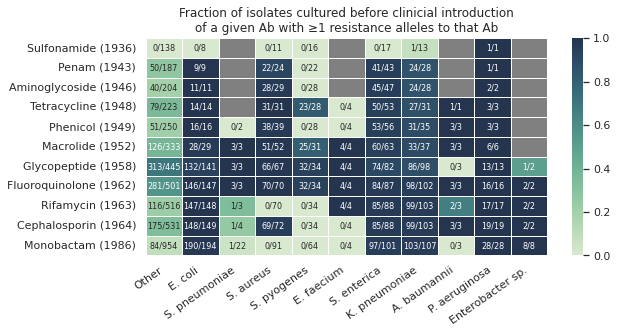

In [11]:
sns.set_theme(font="Arial", style="white")
g = sns.heatmap(
    fracresist_df,
    annot=countresist_df,
    fmt="",
    cbar_kws={
        # "label": "Fraction of isolates with ≥1 resistance \nelement(s) before Ab introduction"
    },
    annot_kws={"size": 8},
    cmap=sns.cubehelix_palette(start=3.1, rot=-0.5, dark=0.2, light=0.88, as_cmap=True),
    # cmap=sns.cubehelix_palette(start=2.9, rot=-.16, dark=0, light=.97, as_cmap=True),
    linewidths=0.5,
)
g.set_facecolor("gray")
g.set(
    title="Fraction of isolates cultured before clinicial introduction\nof a given Ab with ≥1 resistance alleles to that Ab"
)

figure = plt.gcf()  # get current figure
figure.set_size_inches(9, 4)
# figure.set_size_inches(7.6, 4.5)

plt.xticks(rotation=35, ha="right")
plt.savefig(
    "./figs/fig2/heatmap_preab-resist_card.svg",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)

In [10]:
df.loc[df['Year_Cultured']>2000].drop_duplicates('Accession_Number')

,Accession_Number,Strain,Assembly_No,Year_Cultured,ORF_ID,Contig,Start,Stop,Orientation,Cut_Off,...,Resistance Mechanism,AMR Gene Family,Predicted_DNA,Predicted_Protein,CARD_Protein_Sequence,Percentage Length of Reference Sequence,ID,Model_ID,Nudged,Note
369,NCTC13435,Staphylococcus aureus,3,2003,NoAb,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1072,NCTC13798,Neisseria gonorrhoeae,1,2015,ENA|LT906440|LT906440.1_1499 # 1476201 # 14781...,ENA|LT906440|LT906440.1_1499,1476201.0,1478135.0,-,Strict,...,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,ATGAGCTTGATCGAATGTAAAAACATCAACCGCTGCTTCGGCAGCG...,MSLIECKNINRCFGSGENRVHILKDISLSIEKGDFVAIIGQSGSGK...,MSLIECKNINRYFGSGENRVHILKDISLSIEKGDFVAIIGQSGSGK...,100.00,gnl|BL_ORD_ID|446|hsp_num:0,487.0,NaN,NaN
1135,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_933 # 1058017 # 105820...,ENA|CP043727|CP043727.1_933,1058017.0,1058202.0,+,Strict,...,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,ATGCTTATTCTGACTCGTCGAGTTGGTGAAACACTCATGATTGGCG...,MLILTRRVGETLMIGDEVTVTVLGVKGNQVRIGVNAPKEVSVHREE...,MLILTRRVGETLMVGDDVTVTVLGVKGNQVRIGVNAPKEVAVHREE...,100.00,gnl|BL_ORD_ID|2800|hsp_num:0,3807.0,NaN,NaN
1434,NCTC13805,Neisseria gonorrhoeae,1,2015,UATF01000009.1_1387 # 1409034 # 1410968 # -1 #...,UATF01000009.1_1387,1409034.0,1410968.0,-,Strict,...,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,ATGAGCTTGATCGAATGTAAAAACATCAACCGCTGCTTCGGCAGCG...,MSLIECKNINRCFGSGENRVHILKDISLSIEKGDFVAIIGQSGSGK...,MSLIECKNINRYFGSGENRVHILKDISLSIEKGDFVAIIGQSGSGK...,100.00,gnl|BL_ORD_ID|446|hsp_num:0,487.0,NaN,NaN
1826,NCTC13779,Enterococcus faecalis,1,2007,UGJA01000001.1_34 # 24255 # 24902 # 1 # ID=1_3...,UGJA01000001.1_34,24255.0,24902.0,+,Perfect,...,antibiotic inactivation,chloramphenicol acetyltransferase (CAT),ATGACTTTTAATATTATTAATTTAGAAACTTGGGATAGAAAAGAAT...,MTFNIINLETWDRKEYFNHYFNQQTTYSVTKELDITLLKSMIKDKG...,MTFNIINLETWDRKEYFNHYFNQQTTYSVTKELDITLLKSMIKDKG...,100.00,gnl|BL_ORD_ID|2511|hsp_num:0,2895.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29988,NCTC13668,Bordetella pertussis,1,2012,UIGD01000003.1_291 # 301771 # 302103 # 1 # ID=...,UIGD01000003.1_291,301771.0,302103.0,+,Strict,...,antibiotic efflux,small multidrug resistance (SMR) antibiotic ef...,ATGAACAGCTGGATCCATCTGTCGATGGCCATCGTGGCCGAAATCA...,MNSWIHLSMAIVAEIIATSALKSSEGFTRLLPSLVTVAGYAIAFYF...,MHYLYLFISIATEIIGTSFLKTSEGFTKLWPTLGTLLSFGICFYFL...,102.80,gnl|BL_ORD_ID|4668|hsp_num:0,5731.0,NaN,NaN
30449,NCTC13463,Escherichia coli,1,2006,UFZC01000006.1_37 # 29157 # 30029 # 1 # ID=1_3...,UFZC01000006.1_37,29154.0,30030.0,+,Perfect,...,antibiotic inactivation,CTX-M beta-lactamase,ATGATGAGACATCGCGTTAAGCGGATGATGCTAATGACAACGGCCT...,MMRHRVKRMMLMTTACISLLLGSAPLYAQANDVQQKLAALEKSSGG...,MMRHRVKRMMLMTTACISLLLGSAPLYAQANDVQQKLAALEKSSGG...,99.66,gnl|BL_ORD_ID|673|hsp_num:0,729.0,True,"possible complete gene, missing n-terminus"
30851,NCTC13802,Neisseria gonorrhoeae,1,2015,UGRB01000001.1_62 # 62042 # 63196 # 1 # ID=1_6...,UGRB01000001.1_62,62042.0,63196.0,+,Strict,...,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,ATGGAAACGCACACAGACGAAACAAAACTTCAAAACACGCAAGTCA...,METHTDETKLQNTQVKRKRRLTALTLLFALSAAAAGSAFFLWWQHE...,MDTHTDETKLQNTQAKRKRRLTALTLLFALAAAAAGSAFFLWWQHE...,100.00,gnl|BL_ORD_ID|2196|hsp_num:0,2428.0,NaN,NaN
31228,NCTC13751,Streptococcus pyogenes,1,2015,ENA|LS483437|LS483437.1_179 # 203299 # 205005 ...,ENA|LS483437|LS483437.1_179,203299.0,205005.0,+,Strict,...,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,ATGCTTAAAGACGCAATCTTACGTTATAAATGGTATGCTTTAGGCT...,MLKDAILRYKWYALGSFFMVIGVVASSLLQPHYLKSVLSAVIQNNQ...,MLIQKIKTYKWQALASLLMTGLMVASSLLQPRYLQEVLGALLTGKY...,100.71,gnl|BL_ORD_ID|1909|hsp_num:0,2081.0,NaN,NaN


In [8]:
df.columns

Index(['Accession_Number', 'Strain', 'Assembly_No', 'Year_Cultured', 'ORF_ID',
       'Contig', 'Start', 'Stop', 'Orientation', 'Cut_Off', 'Pass_Bitscore',
       'Best_Hit_Bitscore', 'Best_Hit_ARO', 'Best_Identities', 'ARO',
       'Model_type', 'SNPs_in_Best_Hit_ARO', 'Other_SNPs', 'Drug Class',
       'Resistance Mechanism', 'AMR Gene Family', 'Predicted_DNA',
       'Predicted_Protein', 'CARD_Protein_Sequence',
       'Percentage Length of Reference Sequence', 'ID', 'Model_ID', 'Nudged',
       'Note'],
      dtype='object')

# AMRFinder Plus

In [12]:
drugyear_usage_amrfinder = {
    "FOSFOMYCIN": 1971,
    "BETA-LACTAM": 1943,
    "PHENICOL/QUINOLONE": 1949,
    "TETRACYCLINE": 1948,
    "CEPHALOSPORIN": 1964,
    "COLISTIN": 1959,
    "SULFONAMIDE": 1936,
    "QUINOLONE": 1962,
    "STREPTOMYCIN": 1948,  # when first clinical trial ended
    "CHLORAMPHENICOL": 1949,
    "KANAMYCIN": 1957,  # when first described in lit
    "MACROLIDE": 1952,
    "FLUOROQUINOLONE": 1962,
    "TRIMETHOPRIM": 1962,
    # "RIFAMYCIN": 1963,
    # "AMINOGLYCOSIDE": 1946,
    # "COLISTIN": 1959,
    # "LINCOSAMIDE": 1963,
    # "GLYCOPEPTIDE": 1958,
    # "FUSIDIC ACID": 1962,
}

In [13]:
amrfinder_df = pd.read_csv(
    "../../data/5_amrfinderplus/merged_amrfinderout",
    sep="\t",
    names=[
        "Accession_Number",
        "Protein identifier",
        "Contig id",
        "Start",
        "Stop",
        "Strand",
        "Gene symbol",
        "Sequence name",
        "Scope",
        "Element type",
        "Element subtype",
        "Class",
        "Subclass",
        "Method",
        "Target length",
        "Reference sequence length",
        "Coverage of reference sequence",
        "% Identity to reference sequence",
        "Alignment length",
        "Accession of closest sequence",
        "Name of closest sequence",
        "HMM id",
        "HMM description",
    ],
)
amrfinder_df = pd.merge(
    amrfinder_df,
    df.drop_duplicates("Accession_Number")[
        ["Accession_Number", "Species", "Year_Cultured"]
    ],
    on="Accession_Number",
    how="left",
)
amrfinder_df["Species"].value_counts()

Other               1613
E. coli              623
S. aureus            554
K. pneumoniae        452
P. aeruginosa        319
S. enterica          106
A. baumannii          87
S. pyogenes           82
Enterobacter sp.      63
S. pneumoniae         48
E. faecium            25
Name: Species, dtype: int64

In [14]:
# amrfinder_df["CleanSpecies"] = amrfinder_df["Species"]
# amrfinder_df.loc[
#     amrfinder_df["Species"].str.contains("Enterococcous faecium"), ["CleanSpecies"]
# ] = "Enterococcus faecium"
# amrfinder_df.loc[
#     amrfinder_df["Species"].str.contains("Salmonella enterica"), ["CleanSpecies"]
# ] = "Salmonella enterica"
# amrfinder_df.loc[
#     amrfinder_df["Species"].str.contains("Klebsiella pneumoniae"), ["CleanSpecies"]
# ] = "Klebsiella pneumoniae"
# amrfinder_df.loc[
#     amrfinder_df["Species"].str.contains("Acinetobacter baumannii"), ["CleanSpecies"]
# ] = "Acinetobacter baumannii"
# amrfinder_df.loc[
#     amrfinder_df["Species"].str.contains("Pseudomonas aeruginosa"), ["CleanSpecies"]
# ] = "Pseudomonas aeruginosa"


# amrfinder_df.loc[
#     amrfinder_df["Species"].str.contains("Enterobacter"), ["CleanSpecies"]
# ] = "Enterobacter sp."
# family_name = amrfinder_df["CleanSpecies"].str.split(" ", expand=True)[0].str[0]
# species_name = amrfinder_df["CleanSpecies"].str.split(" ", expand=True)[1]
# amrfinder_df["Species"] = family_name + ". " + species_name
# amrfinder_df
# amrfinder_df.loc[
#     amrfinder_df["Species"].str.match("E. sp."), ["Species"]
# ] = "Enterobacter sp."
# amrfinder_df.loc[
#     ~amrfinder_df["Species"].str.contains(
#         "P. aeruginosa|S. enterica|E. faecium|K. pneumoniae|A. baumannii|Enterobacter sp.|E. coli|S. pneumoniae|S. aureus|S. pyogenes"
#     ),
#     ["Species"],
# ] = "Other"
# amrfinder_df["Species"].value_counts()

In [15]:
x = {}
frac_resist = {}
count_resist = {}
index = []
# g = pd.DataFrame(columns=eskape_pathogens['CleanSpecies'].drop_duplicates())
for j in sorted(drugyear_usage_amrfinder.items(), key=lambda i: i[1], reverse=False):
    d = j[0]
    # print(f"{d}\t{drugyear_usage[d]}")
    x[d] = []
    x[d].append(
        amrfinder_df.loc[
            (
                (amrfinder_df["Class"].str.contains(d))
                | (amrfinder_df["Subclass"].str.contains(d))
            )
            & (amrfinder_df["Year_Cultured"] < drugyear_usage_amrfinder[d])
        ]
    )
    x[d].append(
        amrfinder_df.loc[amrfinder_df["Year_Cultured"] < drugyear_usage_amrfinder[d]]
    )
    name = d.replace(" antibiotic", "")
    name = name + f" ({drugyear_usage_amrfinder[d]})"
    index.append(name.title())
    # print(d)
    for j in [
        "Other",
        "E. coli",
        "S. pneumoniae",
        "S. aureus",
        "S. pyogenes",
        "E. faecium",
        "S. enterica",
        "K. pneumoniae",
        "A. baumannii",
        "P. aeruginosa",
        "Enterobacter sp.",
    ]:
        # print(j)
        if j not in frac_resist:
            frac_resist[j] = []
            count_resist[j] = []
        try:
            vc_res_isolates = (
                x[d][0].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_res_isolates)
        except:
            vc_res_isolates = 0
        try:
            vc_all_isolates = (
                x[d][1].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_all_isolates)

        except:
            frac_resist[j].append("NaN")
            count_resist[j].append(0)
            continue
            # vc_all_isolates = 1
        # print(f"{j}\t{vc_res_isolates/vc_all_isolates}\t{vc_res_isolates}\t{vc_all_isolates}")
        frac_resist[j].append(vc_res_isolates / vc_all_isolates)

        # lower_bound, upper_bound = calculate_frequency_bounds(vc_res_isolates, vc_all_isolates)
        # count_resist[j].append(f"{lower_bound:.2f}-{upper_bound:.2f}")
        count_resist[j].append(f"{vc_res_isolates}/{vc_all_isolates}")
        # print(vc_res_isolates/vc_all_isolates)

fracresist_df = pd.DataFrame(data=frac_resist, index=index)
countresist_df = pd.DataFrame(data=count_resist, index=index)
fracresist_df.replace("NaN", np.nan, inplace=True)
fracresist_df

,Other,E. coli,S. pneumoniae,S. aureus,S. pyogenes,E. faecium,S. enterica,K. pneumoniae,A. baumannii,P. aeruginosa,Enterobacter sp.
Sulfonamide (1936),0.000000,0.000000,NaN,0.000000,0.0,NaN,0.000000,0.076923,NaN,0.0000,NaN
Beta-Lactam (1943),0.160428,0.000000,NaN,0.083333,0.0,NaN,0.000000,0.500000,NaN,1.0000,NaN
Tetracycline (1948),0.044843,0.071429,NaN,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,NaN
Streptomycin (1948),0.013453,0.000000,NaN,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0000,NaN
Phenicol/Quinolone (1949),0.012000,0.062500,0.0,0.000000,0.0,0.0,0.000000,0.514286,0.000000,0.0000,NaN
Chloramphenicol (1949),0.028000,0.062500,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.0000,NaN
Macrolide (1952),0.057057,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0000,NaN
Kanamycin (1957),0.004619,0.000000,0.0,0.014925,0.0,0.0,0.000000,0.010204,0.333333,1.0000,0.0
Colistin (1959),0.000000,0.326389,0.0,0.000000,0.0,0.0,0.000000,0.030000,0.000000,0.0000,0.0
Quinolone (1962),0.033932,0.102041,0.0,0.000000,0.0,0.0,0.011494,0.764706,0.000000,0.6875,1.0


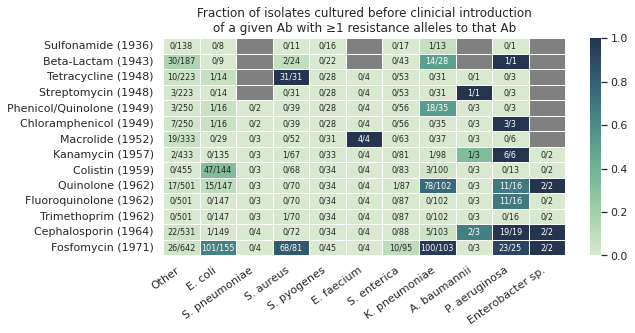

In [16]:
sns.set_theme(font="Arial", style="white")
g = sns.heatmap(
    fracresist_df,
    annot=countresist_df,
    fmt="",
    cbar_kws={
        # "label": "Fraction of isolates with ≥1 resistance \nelement(s) before Ab introduction"
    },
    annot_kws={"size": 8},
    cmap=sns.cubehelix_palette(start=3.1, rot=-0.5, dark=0.2, light=0.88, as_cmap=True),
    # cmap=sns.cubehelix_palette(start=2.9, rot=-.16, dark=0, light=.97, as_cmap=True),
    linewidths=0.5,
)
g.set_facecolor("gray")
g.set(
    title="Fraction of isolates cultured before clinicial introduction\nof a given Ab with ≥1 resistance alleles to that Ab"
)

figure = plt.gcf()  # get current figure
figure.set_size_inches(9, 4)
# figure.set_size_inches(7.6, 4.5)

plt.xticks(rotation=35, ha="right")
plt.savefig(
    "./figs/fig2/heatmap_preab-resist_amrfinder.svg",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


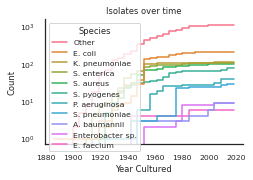

In [17]:
sns.set_theme(font="Arial", style="white", font_scale=0.7)
sns.set_palette("deep")
histogram = sns.histplot(
    data=amrfinder_df.drop_duplicates("Accession_Number"),
    x="Year_Cultured",
    hue="Species",
    # multiple="stack",
    hue_order=amrfinder_df.drop_duplicates("Accession_Number")
    .value_counts("Species")
    .index,
    cumulative=True,
    fill=False,
    # stat='density',
    element="step",
    legend="full",
)
histogram.set(xlabel="Year Cultured", title="Isolates over time")
histogram.set_yscale("log")

legend = histogram.get_legend()
handles = legend.legendHandles
# legend.remove()

# specie_counts = genomeandyear_nctcdf['Specie_Name'].value_counts()
# histogram.legend(handles, topx, title="Species")
# histogram._legend.set_title('Species')
figure = plt.gcf()  # get current figure
figure.set_size_inches(3.55, 2.3)
sns.despine()
plt.savefig(
    "./figs/fig2/year_cultured-cumulativelineplot.svg",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)

# Other versions

## CARD

In [18]:
x = {}
frac_resist = {}
count_resist = {}
index = []
# g = pd.DataFrame(columns=eskape_pathogens['CleanSpecies'].drop_duplicates())
for j in sorted(drugyear_usage.items(), key=lambda i: i[1], reverse=False):
    d = j[0]
    # print(f"{d}\t{drugyear_usage[d]}")
    x[d] = []
    x[d].append(
        eskape_pathogens.loc[
            (eskape_pathogens["Drug Class"].str.contains(d))
            & (eskape_pathogens["Year_Cultured"] < drugyear_usage[d])
        ]
    )
    x[d].append(
        eskape_pathogens.loc[eskape_pathogens["Year_Cultured"] < drugyear_usage[d]]
    )
    name = d.replace(" antibiotic", "")
    name = name + f" ({drugyear_usage[d]})"
    index.append(name.capitalize())
    # print(d)
    for j in [
        "E. faecium",
        "S. enterica",
        "K. pneumoniae",
        "A. baumannii",
        "P. aeruginosa",
        "Enterobacter sp.",
    ]:
        # print(j)
        if j not in frac_resist:
            frac_resist[j] = []
            count_resist[j] = []
        try:
            vc_res_isolates = (
                x[d][0].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_res_isolates)
        except:
            vc_res_isolates = 0
        try:
            vc_all_isolates = (
                x[d][1].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_all_isolates)

        except:
            frac_resist[j].append("NaN")
            count_resist[j].append(0)
            continue
            # vc_all_isolates = 1
        # print(f"{j}\t{vc_res_isolates/vc_all_isolates}\t{vc_res_isolates}\t{vc_all_isolates}")
        frac_resist[j].append(vc_res_isolates / vc_all_isolates)
        count_resist[j].append(f"{vc_res_isolates}/{vc_all_isolates}")
        # print(vc_res_isolates/vc_all_isolates)
fracresist_df = pd.DataFrame(data=frac_resist, index=index)
countresist_df = pd.DataFrame(data=count_resist, index=index)
fracresist_df.replace("NaN", np.nan, inplace=True)
fracresist_df

,E. faecium,S. enterica,K. pneumoniae,A. baumannii,P. aeruginosa,Enterobacter sp.
Sulfonamide (1936),NaN,NaN,NaN,NaN,NaN,NaN
Penam (1943),NaN,NaN,NaN,NaN,NaN,NaN
Aminoglycoside (1946),NaN,NaN,NaN,NaN,NaN,NaN
Tetracycline (1948),NaN,NaN,NaN,NaN,NaN,NaN
Phenicol (1949),NaN,NaN,NaN,NaN,NaN,NaN
Macrolide (1952),NaN,NaN,NaN,NaN,NaN,NaN
Glycopeptide (1958),NaN,NaN,NaN,NaN,NaN,NaN
Fluoroquinolone (1962),NaN,NaN,NaN,NaN,NaN,NaN
Rifamycin (1963),NaN,NaN,NaN,NaN,NaN,NaN
Cephalosporin (1964),NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
fracresist_df = pd.DataFrame(
    columns=[
        "Species",
        "Antibiotic",
        "Year Introduced",
        "Fraction of Resistant Isolates pre-Ab",
        "Total isolates Pre-Ab",
        "Resistant Isolates Pre-Ab",
    ]
)

x = {}
frac_resist = {}
count_resist = {}
index = []
# g = pd.DataFrame(columns=eskape_pathogens['CleanSpecies'].drop_duplicates())
for j in sorted(drugyear_usage.items(), key=lambda i: i[1], reverse=False):
    d = j[0]
    # print(f"{d}\t{drugyear_usage[d]}")
    x[d] = []
    x[d].append(
        eskape_pathogens.loc[
            (eskape_pathogens["Drug Class"].str.contains(d))
            & (eskape_pathogens["Year_Cultured"] < drugyear_usage[d])
        ]
    )
    x[d].append(
        eskape_pathogens.loc[eskape_pathogens["Year_Cultured"] < drugyear_usage[d]]
    )
    # name = d.replace(" antibiotic", "")
    # name = name + f" ({drugyear_usage[d]})"
    # index.append(name.capitalize())
    index.append(d)
    # print(d)
    for j in [
        "E. faecium",
        "S. enterica",
        "K. pneumoniae",
        "A. baumannii",
        "P. aeruginosa",
        "Enterobacter sp.",
    ]:
        # print(j)
        if j not in frac_resist:
            frac_resist[j] = []
            count_resist[j] = []
        try:
            vc_res_isolates = (
                x[d][0].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_res_isolates)
        except:
            vc_res_isolates = 0
        try:
            vc_all_isolates = (
                x[d][1].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_all_isolates)
        except:
            frac_resist[j].append("NaN")
            count_resist[j].append(0)
            # fracresist_df = pd.concat([fracresist_df, pd.Series(data={"Species": j, "Antibiotic": d, "Year Introduced": drugyear_usage[d], "Total isolates Pre-Ab": 0, "Resistant Isolates Pre-Ab": 0})], axis=0, ignore_index=True)
            fracresist_df = fracresist_df.append(
                {
                    "Species": j,
                    "Antibiotic": d,
                    "Year Introduced": drugyear_usage[d],
                    "Total isolates Pre-Ab": 0,
                    "Resistant Isolates Pre-Ab": 0,
                    "Fraction of Resistant Isolates pre-Ab": "NaN",
                },
                ignore_index=True,
            )
            continue
            # vc_all_isolates = 1
        # print(f"{j}\t{vc_res_isolates/vc_all_isolates}\t{vc_res_isolates}\t{vc_all_isolates}")
        # frac_resist[j].append(vc_res_isolates / vc_all_isolates)
        # count_resist[j].append(f"{vc_res_isolates}/{vc_all_isolates}")
        # fracresist_df = pd.concat([fracresist_df, pd.Series(data={"Species": j, "Antibiotic": d, "Year Introduced": drugyear_usage[d], "Total isolates Pre-Ab": vc_all_isolates, "Resistant Isolates Pre-Ab": vc_res_isolates})], axis=0, ignore_index=True)
        fracresist_df = fracresist_df.append(
            {
                "Species": j,
                "Antibiotic": d,
                "Year Introduced": drugyear_usage[d],
                "Total isolates Pre-Ab": vc_all_isolates,
                "Resistant Isolates Pre-Ab": vc_res_isolates,
                "Fraction of Resistant Isolates pre-Ab": vc_res_isolates
                / vc_all_isolates,
            },
            ignore_index=True,
        )

        # print(vc_res_isolates/vc_all_isolates)
# fracresist_df = pd.DataFrame(data=frac_resist, index=index)
# countresist_df = pd.DataFrame(data=count_resist, index=index)
fracresist_df.replace("NaN", np.nan, inplace=True)
fracresist_df["Fraction of Resistant Isolates pre-Ab"] = (
    fracresist_df["Resistant Isolates Pre-Ab"] / fracresist_df["Total isolates Pre-Ab"]
)

fracresist_df

/tmp/ipykernel_18012/1488236142.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_18012/1488236142.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_18012/1488236142.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_18012/1488236142.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_18012/1488236142.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_18012/1488236142.py:63: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a 

,Species,Antibiotic,Year Introduced,Fraction of Resistant Isolates pre-Ab,Total isolates Pre-Ab,Resistant Isolates Pre-Ab
0,E. faecium,sulfonamide antibiotic,1936,NaN,0,0
1,S. enterica,sulfonamide antibiotic,1936,NaN,0,0
2,K. pneumoniae,sulfonamide antibiotic,1936,NaN,0,0
3,A. baumannii,sulfonamide antibiotic,1936,NaN,0,0
4,P. aeruginosa,sulfonamide antibiotic,1936,NaN,0,0
...,...,...,...,...,...,...
61,S. enterica,monobactam,1986,NaN,0,0
62,K. pneumoniae,monobactam,1986,NaN,0,0
63,A. baumannii,monobactam,1986,NaN,0,0
64,P. aeruginosa,monobactam,1986,NaN,0,0


/tmp/ipykernel_18012/1000700311.py:94: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6



ValueError: Number of rows must be a positive integer, not 0

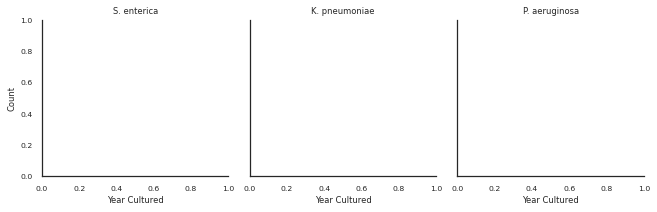

<Figure size 648x0 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style and font
sns.set_theme(font="Arial", style="white", font_scale=0.7)
sns.set_palette("deep")

# Drop duplicate isolates
eskape_isolates = eskape_pathogens.drop_duplicates("Accession_Number")

# Create color scheme for antibiotic introductions
handles = []
labels = []
colors = sns.color_palette("deep", len(drugyear_usage))
drug_to_color = {}
for i, results in enumerate(
    sorted(drugyear_usage.items(), key=lambda i: i[1], reverse=False)
):
    d = results[0]
    year = results[1]
    handles.append(plt.Line2D([], [], color=colors[i], marker="o"))
    labels.append(d.replace(" antibiotic", "").capitalize() + f" ({year})")
    drug_to_color[d] = colors[i]

# Create facet plot for top three species
species_order = ["S. enterica", "K. pneumoniae", "P. aeruginosa"]
g_top = sns.FacetGrid(
    eskape_isolates[eskape_isolates["Species"].isin(species_order)],
    col="Species",
    sharex=True,
    col_wrap=3,
    col_order=species_order,
)

# Map the plot to the "Year Cultured" column
g_top.map(
    sns.histplot,
    "Year_Cultured",
    cumulative=True,
    fill=False,
    element="step",
    color="black",
)

# Add scatter plot for resistant isolates pre-antibiotic usage
g_top.set_axis_labels("Year Cultured", "Count")
for ax, col_name in zip(g_top.axes.flat, g_top.col_names):
    sns.scatterplot(
        data=fracresist_df[
            (fracresist_df["Species"] == col_name)
            & (fracresist_df["Resistant Isolates Pre-Ab"] != 0)
        ],
        x="Year Introduced",
        y="Resistant Isolates Pre-Ab",
        edgecolor="none",
        ax=ax,
    )
    # reset title of plots
    ax.set(title=col_name)
    # Add vertical lines and labels for antibiotic introductions
    for i, (drug, year) in enumerate(drugyear_usage.items()):

        drugspec = fracresist_df[
            (fracresist_df["Species"] == col_name)
            & (fracresist_df["Antibiotic"] == drug)
        ]
        if drugspec["Resistant Isolates Pre-Ab"].iat[0] == 0:
            continue
        sns.scatterplot(
            data=fracresist_df[
                (fracresist_df["Species"] == col_name)
                & (fracresist_df["Resistant Isolates Pre-Ab"] != 0)
                & (fracresist_df["Antibiotic"] == drug)
            ],
            x="Year Introduced",
            y="Resistant Isolates Pre-Ab",
            edgecolor="none",
            ax=ax,
            color=drug_to_color[drug],
        )
        ax.axvline(
            x=year, color=drug_to_color[drug], linestyle="--", linewidth=1, alpha=0.7
        )
        # ax.text(
        #     year - 1,
        #     ax.get_ylim()[1] * 0.6,
        #     drug.replace(" antibiotic", "").capitalize(),
        #     rotation=90,
        #     ha="center",
        #     va="top",
        #     fontsize=6,
        # )
# Save the figure
plt.savefig(
    "./figs/fig2/fig2_top.svg", dpi=300, bbox_inches="tight", figsize=(7.4, 2.5)
)

# Create facet plot for bottom three species
g_bottom = sns.FacetGrid(
    eskape_isolates[
        eskape_isolates["Species"].isin(
            ["E. faecium", "A. baumannii", "Enterobacter sp."]
        )
    ],
    col="Species",
    sharex=True,
    col_wrap=3,
)

# Map the plot to the "Year Cultured" column
g_bottom.map(
    sns.histplot,
    "Year_Cultured",
    cumulative=True,
    fill=False,
    element="step",
    legend=False,
    color="black",
)

# Add labels for the x and y axes
g_bottom.set_axis_labels("Year Cultured", "Count")
g_bottom.set(ylim=(0, 15))

# Loop through the facet plots and add a scatter plot on top of each plot
for ax, col_name in zip(g_bottom.axes.flat, g_bottom.col_names):

    # reset title of plots
    ax.set(title=col_name)

    # Add vertical lines and labels for antibiotic introductions
    for i, (drug, year) in enumerate(drugyear_usage.items()):

        drugspec = fracresist_df[
            (fracresist_df["Species"] == col_name)
            & (fracresist_df["Antibiotic"] == drug)
        ]
        if drugspec["Resistant Isolates Pre-Ab"].iat[0] == 0:
            continue
        sns.scatterplot(
            data=fracresist_df[
                (fracresist_df["Species"] == col_name)
                & (fracresist_df["Resistant Isolates Pre-Ab"] != 0)
                & (fracresist_df["Antibiotic"] == drug)
            ],
            x="Year Introduced",
            y="Resistant Isolates Pre-Ab",
            edgecolor="none",
            ax=ax,
            color=drug_to_color[drug],
        )
        ax.axvline(
            x=year, color=drug_to_color[drug], linestyle="--", linewidth=1, alpha=0.7
        )
        # ax.text(
        #     year - 1,
        #     ax.get_ylim()[1] * 0.6,
        #     drug.replace(" antibiotic", "").capitalize(),
        #     rotation=90,
        #     ha="center",
        #     va="top",
        #     fontsize=6,
        # )

    ax.set_yticks(range(0, 16, 5))
# print(handles)
# print(labels)
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))
# Save the figure
plt.savefig(
    "./figs/fig2/fig2_bottom.svg", dpi=300, bbox_inches="tight", figsize=(7.4, 2.5)
)

In [ ]:
drugyear_usage = {
    "fluoroquinolone antibiotic": 1962,
    "penam": 1943,
    "cephalosporin": 1964,
    "tetracycline antibiotic": 1948,
    "phenicol antibiotic": 1949,
    "macrolide antibiotic": 1952,
    "rifamycin antibiotic": 1963,
    "aminoglycoside antibiotic": 1946,
    # "peptide antibiotic": 1941,  # not sure about this one
    # "glycylcycline": 1948,  # using year tetracyclines were introduced clinically
    # "triclosan": 1968,  # using wiki page
    # "cephamycin": 1964,  # using cephalosporin year
    "carbapenem": 1985,
    # "aminocoumarin antibiotic": 1965,  # best guess from wiki article
    # "penem": 1985,  # using year carbapenems were introduced
    "monobactam": 1986,
    # "disinfecting agents and intercalating dyes": 1930,  # no clue
    # "acridine dye": 1970,  # no clue?
    # "diaminopyrimidine antibiotic": 1962,
    # "elfamycin antibiotic": 1978,  # no clue
    # "fosfomycin": 1971,
    # "nucleoside antibiotic": 2014,  # no clue, but looks newish
    "lincosamide antibiotic": 1963,
    # "nitroimidazole antibiotic": 1960,
    # "Null": 1920,
    # "benzalkonium chloride": 1950,  # no clude
    # "rhodamine": 1950,  # no clude
    "sulfonamide antibiotic": 1936,
    "nitrofuran antibiotic": 1953,
    # "streptogramin antibiotic": 1965,
    # "oxazolidinone antibiotic": 2000,
    "glycopeptide antibiotic": 1958,
    # "fusidic acid": 1962,
    # "pleuromutilin antibiotic": 2007,
    # "bicyclomycin": 1972,  # from wiki
    # "antibacterial free fatty acids": 2000,  # noclude
    # "para-aminosalicylic acid": 1943,
    # "isoniazid": 1952,
    # "polyamine antibiotic": 2005,  # no idea
}

In [ ]:
import scipy.stats as stats
from scipy.stats import binom


def calculate_frequency_bounds(succ, att, confidence=0.95):

    freq = succ / att
    alpha = succ + 1
    beta = att - succ + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    # return (freq - lower_b, upper_b - freq)
    return (lower_b, upper_b)

In [ ]:
x = {}
frac_resist = {}
count_resist = {}
index = []
# g = pd.DataFrame(columns=eskape_pathogens['CleanSpecies'].drop_duplicates())
for j in sorted(drugyear_usage.items(), key=lambda i: i[1], reverse=False):
    d = j[0]
    # print(f"{d}\t{drugyear_usage[d]}")
    x[d] = []
    x[d].append(
        eskape_pathogens.loc[
            (eskape_pathogens["Drug Class"].str.contains(d))
            & (eskape_pathogens["Year_Cultured"] < drugyear_usage[d])
        ]
    )
    x[d].append(
        eskape_pathogens.loc[eskape_pathogens["Year_Cultured"] < drugyear_usage[d]]
    )
    name = d.replace(" antibiotic", "")
    name = name + f" ({drugyear_usage[d]})"
    index.append(name.capitalize())
    # print(d)
    for j in [
        "E. faecium",
        "S. enterica",
        "K. pneumoniae",
        "A. baumannii",
        "P. aeruginosa",
        "Enterobacter sp.",
    ]:
        # print(j)
        if j not in frac_resist:
            frac_resist[j] = []
            count_resist[j] = []
        try:
            vc_res_isolates = (
                x[d][0].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_res_isolates)
        except:
            vc_res_isolates = 0
        try:
            vc_all_isolates = (
                x[d][1].drop_duplicates("Accession_Number")["Species"].value_counts()[j]
            )
            # print(vc_all_isolates)

        except:
            frac_resist[j].append("NaN")
            count_resist[j].append(0)
            continue
            # vc_all_isolates = 1
        # print(f"{j}\t{vc_res_isolates/vc_all_isolates}\t{vc_res_isolates}\t{vc_all_isolates}")
        frac_resist[j].append(vc_res_isolates / vc_all_isolates)

        # lower_bound, upper_bound = calculate_frequency_bounds(vc_res_isolates, vc_all_isolates)
        # count_resist[j].append(f"{lower_bound:.2f}-{upper_bound:.2f}")
        count_resist[j].append(f"{vc_res_isolates}/{vc_all_isolates}")
        # print(vc_res_isolates/vc_all_isolates)
fracresist_df = pd.DataFrame(data=frac_resist, index=index)
countresist_df = pd.DataFrame(data=count_resist, index=index)
fracresist_df.replace("NaN", np.nan, inplace=True)
fracresist_df

In [ ]:
countresist_df

In [ ]:
sns.set_theme(font="Arial", style="white")
g = sns.heatmap(
    fracresist_df,
    annot=countresist_df,
    fmt="",
    cbar_kws={
        "label": "Fraction of isolates with ≥1 resistance \nelement(s) before Ab introduction"
    },
    annot_kws={"size": 10},
    cmap=sns.cubehelix_palette(start=3.1, rot=-0.5, dark=0.1, light=0.93, as_cmap=True)
    # cmap=sns.cubehelix_palette(start=2.9, rot=-.16, dark=0, light=.97, as_cmap=True)#sns.color_palette("rocket", as_cmap=True)
    ,
    linewidths=0.5,
)
g.set_facecolor("gray")
g.set(
    title="Number of ESKAPE pathogen isolates cultured before \nclinicial introduction of a given Ab"
)

figure = plt.gcf()  # get current figure
# figure.set_size_inches(8, 5)
figure.set_size_inches(7.6, 4.5)

plt.xticks(rotation=35, ha="right")
plt.savefig(
    "./figs/fig2/eskape-heatmap_preab-resist.svg",
    dpi=300,
    bbox_inches="tight",
    transparent=False,
)